# Turbulence diagnostics
After completing the post-processing, we can now move on to looking at some turbulence diagnostics. 
Based on the generated half-hourly output of the first notebook ([01_post-processing.ipynb](https://github.com/noctiluc3nt/ec_analyze/blob/main/notebooks/01_post-processing.ipynb)) some standard turbulence quantities, i.e. stability parameter, friction velocity, TKE, turbulence intensity are calculated and plotted, which allows to study turbulent flow properties systematically.

## Standard turbulence diagnostics and fluxes
Here, some functions from the Reddy package are used to calculate turbulent kinetic energy $TKE$, velocity scale of TKE $V_{TKE}$, horizontal turbulence intensity $TI$, vertical turbulence intensity $I_w$, friction velocity $u_*$, Obukhov length $L$, stability parameter $\zeta$ and directional shear angle and plot their timeseries for the previously post-processed example data. <br>


- **Turbulence intensity** (`calc_ti` and `calc_iw`): Turbulence intensity generally refers to the standard deviation, e.g., $\sigma_u, \sigma_v, \sigma_w, \sigma_T$, and thus describes the mean fluctuation intensity. The horizontal turbulence intensity TI (`calc_ti`) and the vertical turbulence intensity $I_w$ (`calc_iw`) are calculated by normalizing the respective standard deviations with the mean wind speed $\overline{u}$ (to get a dimensionless measure):
$$TI = \frac{\sqrt{\sigma_u^2+\sigma_v^2}}{\overline{u}} ,\quad\quad I_w= \frac{\sigma_w}{\overline{u}} $$
- **Turbulent kinetic energy TKE** (`calc_tke`): TKE describes the mean kinetic energy that the eddies contain and is calculated by
 $$ TKE = 0.5 (\sigma_u^2 + \sigma_v^2 + \sigma_w^2) =0.5 (\overline{u'^2} + \overline{v'^2} + \overline{w'^2}  ).$$
 From the TKE, a velocity scale can easily be derived $V_{TKE} = \sqrt{TKE}$ (`calc_vtke`).
- **Friction velocity** $u_*$ (`calc_ustar`): The friction velocity describes the effect of friction in form of a velocity scale
$$ u_* = \sqrt[4]{\overline{u'v'}^2+\overline{v'w'}^2}.$$
If the **surface roughness** $z_0$ (`ustar2z0`) is not known, friction velocity can also be used to estimate it with an simple estimate
$$z_0 = \alpha \frac{u_*^2}{g}$$
with the Charnock constant $\alpha = 0.016$ and $g=9.81$ m/s.
- **Obukhov length** $L$ (`calc_L`): The Obukhov length is a length scale that describes the effect of buoyancy versus shear (friction velocity) through
$$ L = -\frac{u_*^3 \overline{T_v}}{\kappa \,g\,\overline{w'T'}}, $$
and is central in Monin-Obukhov similarity theory (MOST) for deriving dimensionless scaling parameters, in particular the stability parameter $\zeta$.
The fluxes used in the calculation are either the surface fluxes for global scaling [@Monin1954] or the fluxes at the measurement height for local scaling [@Nieuwstadt1984].
- **Stability parameter** $\zeta$ (`calc_zeta`): The stability parameter is the ratio of measurement height and Obukhov length, and thus a dimensionless measure for stability
$$ \zeta = \frac{z}{L}.$$
$\zeta$ is negative in unstable stratification, zero in neutral stratification, and positive in stable stratification, which can be traced back to the sign of the heat flux $\overline{w'T'}$ in the Obukhov length $L$.

Now, we use some of the Reddy functions to calculate and plot time series of these basic turbulent diagnostics.

In [1]:
#loading Reddy package
install.packages("../src/Reddy_0.0.0.9000.tar.gz",repos=NULL,source=TRUE,quiet=TRUE)
library(Reddy)
library(latex2exp)

In [2]:
#read in processed example data
dat=readRDS("../data/ec-data_30min_processed/processed_data_example.rds")

In [3]:
#calculation of some useful turbulence diagnostics
dat$tke=calc_tke(dat$u_sd,dat$v_sd,dat$w_sd)
dat$vtke=calc_vtke(dat$u_sd,dat$v_sd,dat$w_sd)
dat$ti=calc_ti(dat$u_sd,dat$v_sd,dat$ws_mean)
dat$iw=calc_iw(dat$w_sd,dat$ws_mean)
dat$ustar=calc_ustar(dat$cov_uw,dat$cov_vw)
dat$L=calc_L(dat$ustar,dat$T_mean,dat$cov_wT)
dat$zeta=calc_zeta(4.4,dat$L)
dat$alpha_uw=calc_dshear(dat$cov_uw,dat$cov_vw)

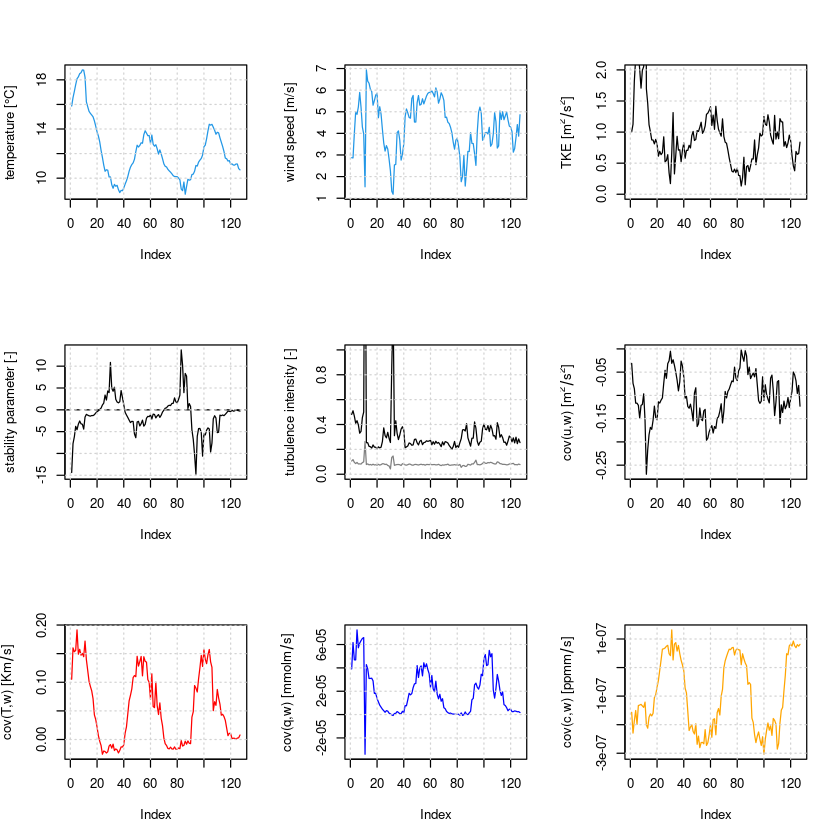

In [6]:
#simple timeseries plots
par(mfrow=c(3,3))
plot(dat$T_mean,type="l",ylab="temperature [°C]",col=4)
grid()
plot(dat$ws_mean,type="l",ylab="wind speed [m/s]",col=4)
grid()
plot(dat$tke,type="l",ylab=TeX("TKE [$m^2/s^2$]"),ylim=c(0,2))
grid()
plot(dat$zeta,type="l",ylab="stability parameter [-]")
abline(h=0,lty=2)
grid()
plot(dat$ti,type="l",ylab="turbulence intensity [-]",ylim=c(0,1))
points(dat$iw,type="l",col="gray50")
grid()
plot(dat$cov_uw,type="l",ylab=TeX("cov(u,w) [$m^2/s^2$]"))
grid()
plot(dat$cov_wT,type="l",ylab=TeX("cov(T,w) [$K m/s$]"),col="red")
grid()
plot(dat$cov_h2ow,type="l",ylab=TeX("cov(q,w) [$mmol m/s$]"),col="blue")
grid()
plot(dat$cov_co2w,type="l",ylab=TeX("cov(c,w) [$ppm m/s$]"),col="orange")
grid()

As we can see, the stratification is unstable during daytime, where also the latent heat flux is positive, indicating evapotranspiration. The momentum flux is always negative, which indicates downward momentum transport (kinetic energy dissipation) in agreement with a typical logarithmic wind profile. Thereby the magnitude of the momentum flux is higher during daytime in accordance with the higher windspeeds and higher TKE there (shear-generated turbulence). The CO$_2$ flux is negative during daytime (CO$_2$ uptake due to photosynthesis) and positive at nighttime (CO$_2$ release).

## Stability dependence
It is often interesting to investigate the stability dependence of turbulence characteristics, especially since Monin-Obukhov similarity theory (MOST) predicts all dimensionless turbulence characteristics based on the dimensionless stability parameter $\zeta$. A simple way is to plot stability versus a turbulence characteristic and bin the data based on stability intervals. For this the function `binning` can be used, which bins one variable based on another for predefined bins, as exemplified below for the dependence of the sensible heat flux on the stability parameter. The output contains mean, median, 25% and 75% quartile per discrete bin as dataframe. The used variables and the bins can be customized. Such type of analysis is usually applied to longer timeseries and can also be combined with other methods, e.g. quadrant analysis, to study how different coherent structures behave with changing stability, see e.g. @Li2011, @Schmutz2019 or @Mack2024.

122.045246,116.804837,109.052920,129.797163
120.620398,125.471467,75.448402,167.986972
17.306097,12.061651,5.647776,24.415438
1.823135,1.864732,1.093005,2.574063
NA,NA,NA,NA
-3.564331,-3.564331,-3.564331,-3.564331
-11.192381,-12.213284,-13.937180,-8.561890
-18.102981,-19.201199,-22.358905,-14.674265
-8.655841,-10.389901,-11.853905,-6.324807


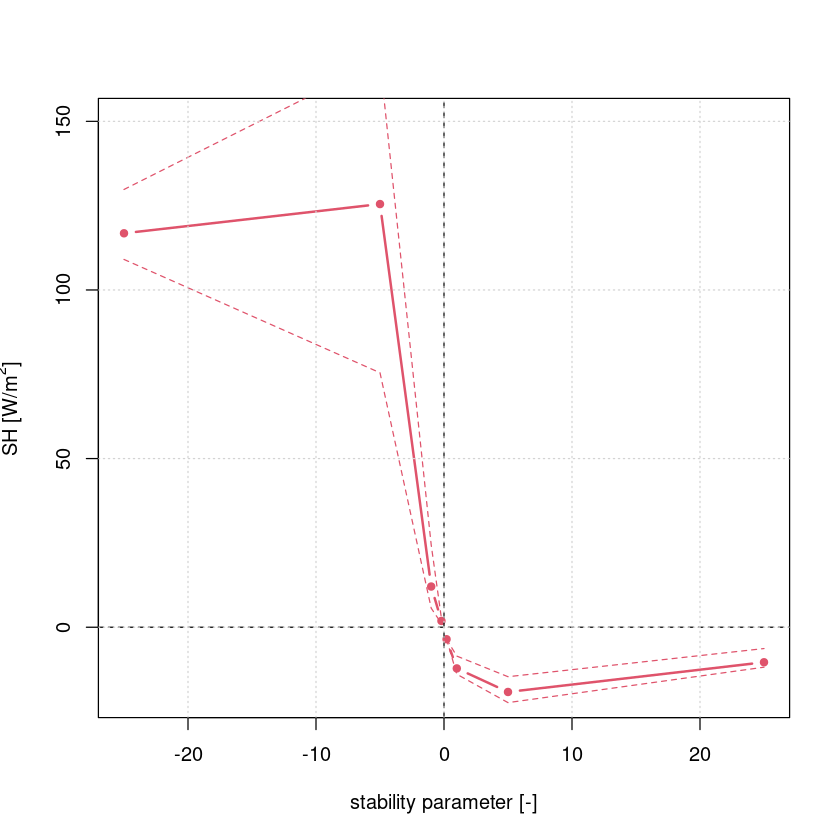

In [7]:
zeta_bins=c(-10^(2:-2),10^(-2:2))
sh_binned=binning(dat$sh,dat$zeta,zeta_bins)
sh_binned #look at output
xbins=c(-5^(2:-1),0,5^(-1:2))
plot(xbins,sh_binned[,2],type="b",ylim=c(-20,150),lwd=2,col=2,pch=20,xlab="stability parameter [-]",ylab=TeX("SH [W/m$^2$]"))
points(xbins,sh_binned[,3],type="l",lty=2,col=2)
points(xbins,sh_binned[,4],type="l",lty=2,col=2)
#polygon(c(xbins,rev(xbins)),c(sh_binned[,3],rev(sh_binned[,4])),lty=0,col=rgb(0.8,0,0,0.2) )
abline(h=0,lty=2)
abline(v=0,lty=2)
grid()

Based on our short example data, we can see that the sensible heat flux is positive under unstable conditions and negative under stable conditions. This can also been seen directly from the definition of $\zeta$ (and $L$ therein). Such type of analysis can be extended to different quantities and binning based on other important scales, e.g. friction velocity. <!-- mention some example studies here-->

## Turbulence regimes and "Hockey-stick" model
The above shown example for stability dependence can be extended to arbitrary variables and is often used to characterize different turbulence regimes. 
To diagnose different turbulence regimes, scatter plots of different turbulence diagnostics can be considered, e.g. plotting wind speed vs TKE or stability parameter vs TKE. For example, @Sun2012 investigate turbulence regimes in stable boundary layers and distinguish between weak and strong turbulence regimes. For this, they plot wind speed versus TKE or $\sigma_w$ and find two different slopes corresponding to different turbulence generation mechanism (local instability versus bulk shear) -- this simple model is now commonly referred to as "Hockey-stick model" (@Sun2012, therein Fig. 2). However, this schematic is very simplified and especially at sites in complex terrain (like our) versatile factors (e.g., the footprint) modify it. In our example data (3 summer days), we see the bulk shear dominated regime, which is indicated by the linear regression.

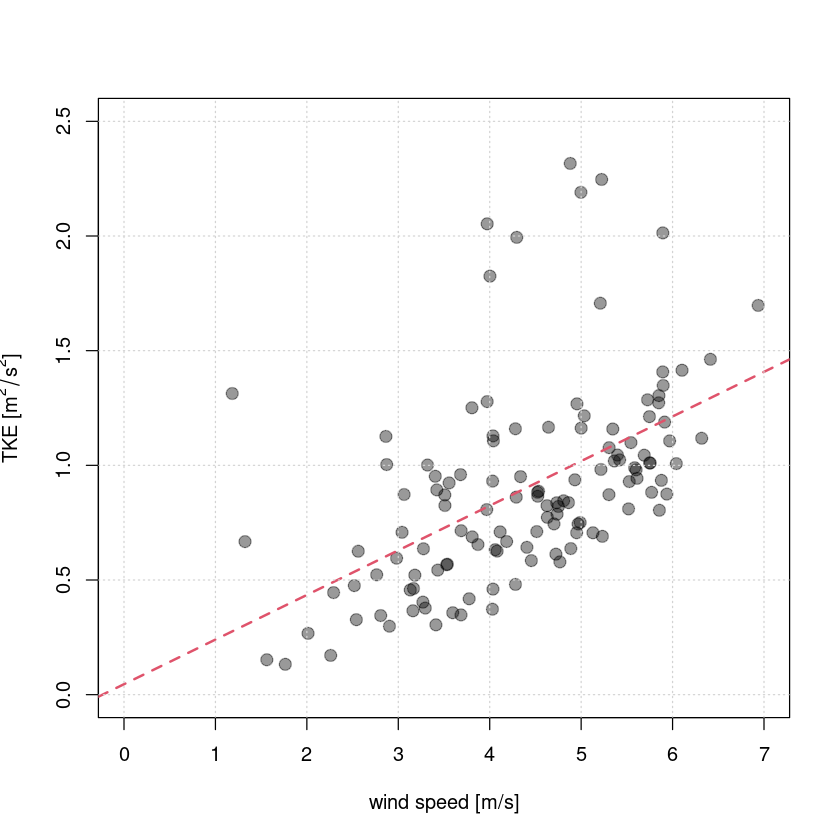

In [9]:
#some basic plots
plot(dat$ws_mean,dat$tke,xlim=c(0,7),ylim=c(0,2.5),xlab="wind speed [m/s]",ylab=TeX("TKE [$m^2/s^2$]"),cex=2,pch=20,col=rgb(0,0,0,0.4))
cond=(dat$ws_mean>4)
fit=lm(dat$tke[cond]~dat$ws_mean[cond])
abline(fit,col=2,lty=2,lwd=2)
#abline(0.1,0.1,col=4,lty=2)
grid()